<a href="https://colab.research.google.com/github/AyraKhans/OCR-Systems/blob/main/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPLEMENTATION
## Training

In [ ]:
#import the necessary python modules
import numpy as np
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import cdist
from skimage.measure import label, regionprops, moments, moments_central, moments_normalized, moments_hu
from skimage import io, exposure
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pickle

## Reading Images and Binarization

#Extracting Characters and their Features




# Train.py

In [ ]:
import numpy as np
from skimage.measure import label, regionprops, moments, moments_central, moments_normalized, moments_hu
from skimage import io, exposure
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def extract_features(image_files, show_plots=True):
    th = 200  # Threshold for binarization

    features = []
    labels = []
    regions_info = []

    for image_file in image_files:
        # Reading image
        img = io.imread(image_file)

        if show_plots:
            # Visualizing the original image
            io.imshow(img)
            plt.title(f'Original Image - {image_file}')
            io.show()

        # Histogram
        hist = exposure.histogram(img)

        if show_plots:
            plt.bar(hist[1], hist[0])
            plt.title(f'Histogram - {image_file}')
            plt.show()

        # Binarization by thresholding
        img_binary = (img < th).astype(np.double)

        if show_plots:
            io.imshow(img_binary)
            plt.title(f'Binary Image - {image_file}')
            io.show()

        # Extracting Characters and their Features
        img_label = label(img_binary, background=0)

        if show_plots:
            io.imshow(img_label)
            plt.title(f'Labeled Image - {image_file}')
            io.show()

        # Computing HU moments and removing small components
        th_component = 200  # Adjust this threshold as needed

        regions = regionprops(img_label)

        fig, ax = plt.subplots()
        ax.imshow(img_binary, cmap='gray')

        for props in regions:
            minr, minc, maxr, maxc = props.bbox
            regions_info.append({'minr': minr, 'minc': minc, 'maxr': maxr, 'maxc': maxc})

            # To omit noise and small size noise components
            if maxr - minr <= th_component and maxc - minc <= th_component:
                ax.add_patch(Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=1))

                # Compute HU moments
                roi = img_binary[minr:maxr, minc:maxc]
                m = moments(roi)
                cc = m[0, 1] / m[0, 0]
                cr = m[1, 0] / m[0, 0]
                mu = moments_central(roi, center=(cr, cc))
                nu = moments_normalized(mu)
                hu = moments_hu(nu)

                # Append HU moments to the features list
                features.append(hu)
                labels.append(image_file.split('.')[0])

        if show_plots:
            ax.set_title(f"\nBounding Boxes and Moments - {image_file}")
            plt.show()

    return features, labels, regions_info




In [ ]:
def normalize_and_save(features, labels, regions_info):
    features = np.array(features)

    mean_values = np.mean(features, axis=0)
    standard_dev = np.std(features, axis=0)

    # store these files
    normalize = (features - mean_values) / standard_dev
    store = {'mean': mean_values, 'std': standard_dev, 'normalize': normalize, 'regions_info': regions_info}

    np.savez('normalization_train.npz', **store)

    # recognition on training data
    D = cdist(normalize, normalize)

    D_index = np.argsort(D, axis=1)
    io.imshow(D)
    plt.title('Distance Matrix')
    io.show()

    neighbor = D_index[:, 1]  # neighbor

    # confusion matrix
    Ytrue = labels
    Ypred = [labels[i] for i in neighbor]

    confM = confusion_matrix(Ytrue, Ypred)

    io.imshow(confM)
    plt.title('Confusion Matrix')
    io.show()


In [ ]:
def calculate_recognition_rate(test_image_file):
    # Load normalization parameters
    normalization_data = np.load('normalization_train.npz')
    mean_values = normalization_data['mean']
    std_dev = normalization_data['std']

    # Read the test image
    test_img = io.imread(test_image_file)

    # Binarization using threshold
    th = 200
    test_img_binary = (test_img < th).astype(np.double)

    # Labeling connected components
    test_img_label = label(test_img_binary, background=0)

    # Extracting characters and their features from the test image
    test_regions = regionprops(test_img_label)
    test_features = []

    for props in test_regions:
        minr, minc, maxr, maxc = props.bbox

        # Compute HU moments
        roi = test_img_binary[minr:maxr, minc:maxc]
        m = moments(roi)
        cc = m[0, 1] / m[0, 0]
        cr = m[1, 0] / m[0, 0]
        mu = moments_central(roi, center=(cr, cc))
        nu = moments_normalized(mu)
        hu = moments_hu(nu)

        # Normalize using training data statistics
        normalized_hu = (hu - mean_values) / std_dev

        # Append normalized HU moments to the features list
        test_features.append(normalized_hu)

    # Recognition on the test data
    D = cdist(test_features, normalization_data['normalize'])
    D_index = np.argsort(D, axis=1)
    neighbor = D_index[:, 0]  # Choose the closest neighbor

    # Calculate recognition rate
    correct_recognitions = sum([1 for i in range(len(test_regions)) if labels[neighbor[i]] == test_image_file.split('.')[0]])
    total_characters = len(test_regions)
    recognition_rate = correct_recognitions / total_characters

    return recognition_rate



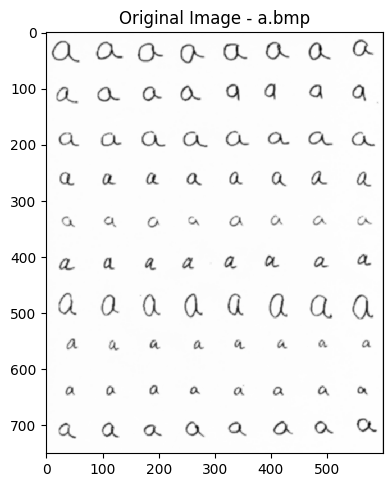

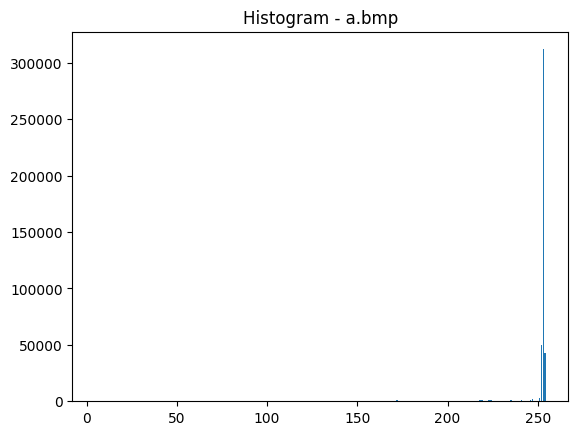

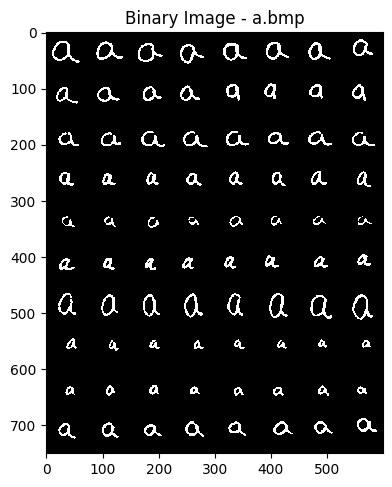

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


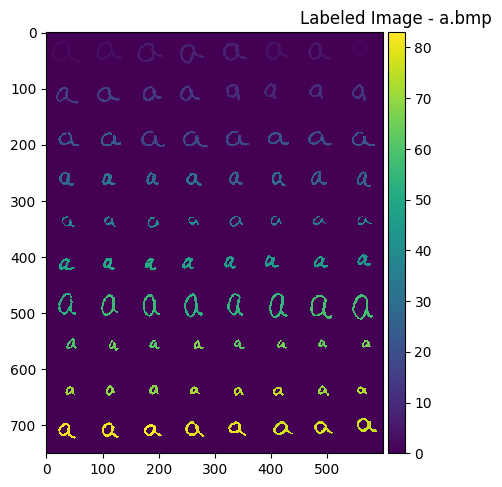

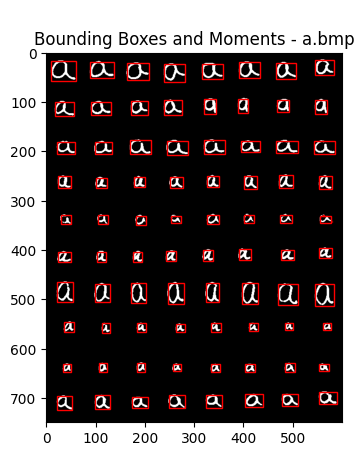

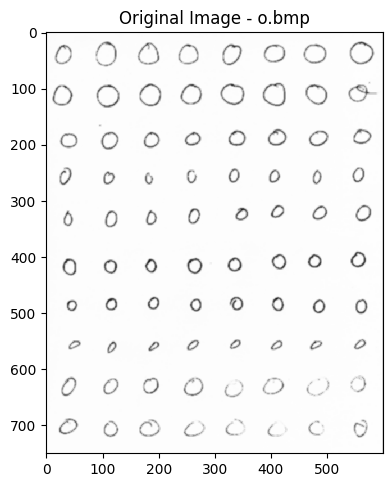

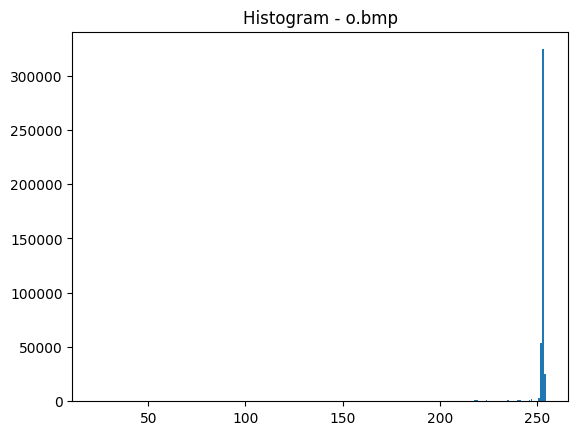

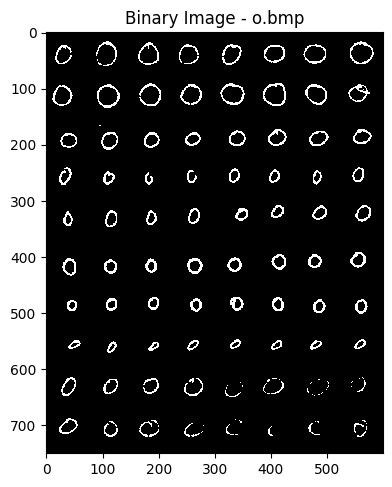

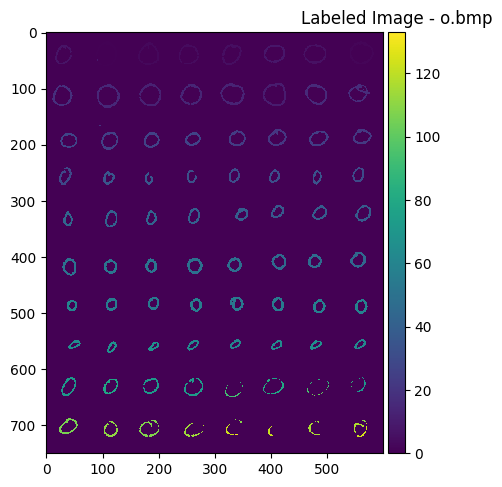

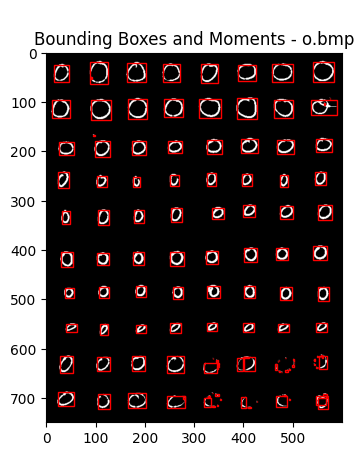

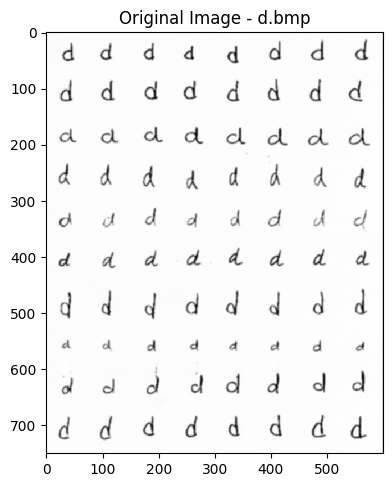

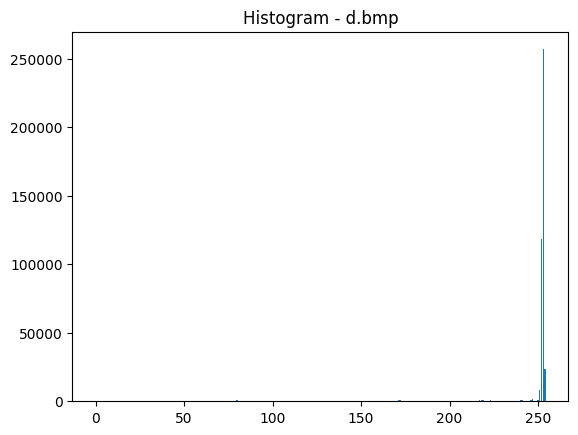

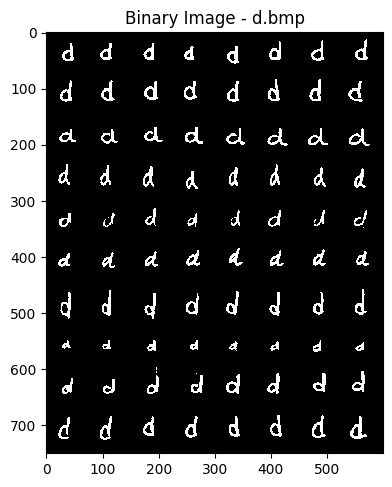

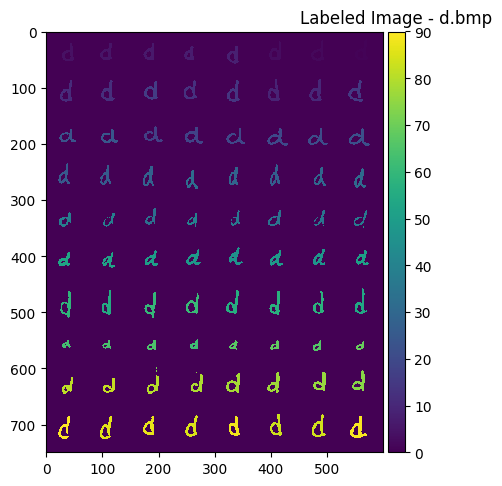

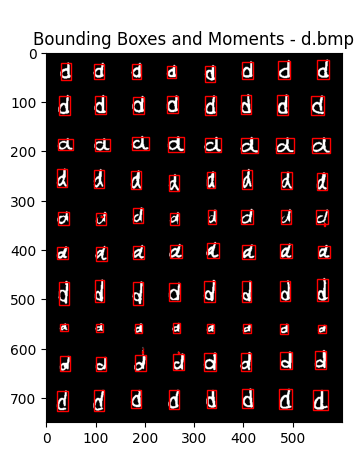

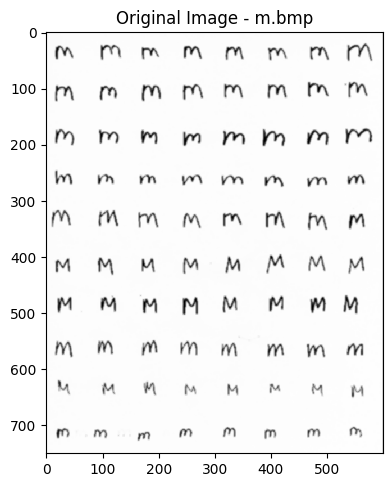

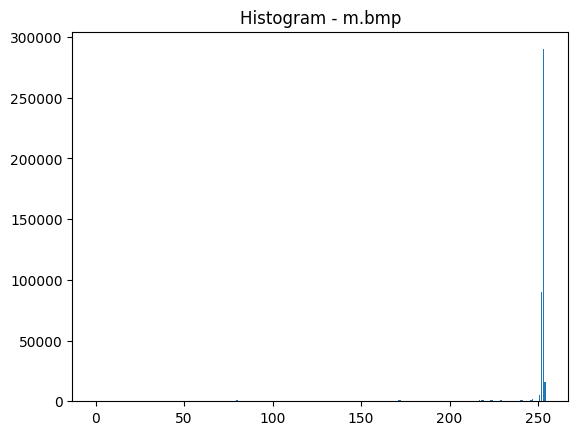

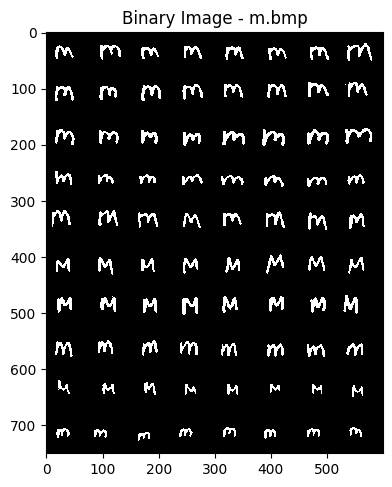

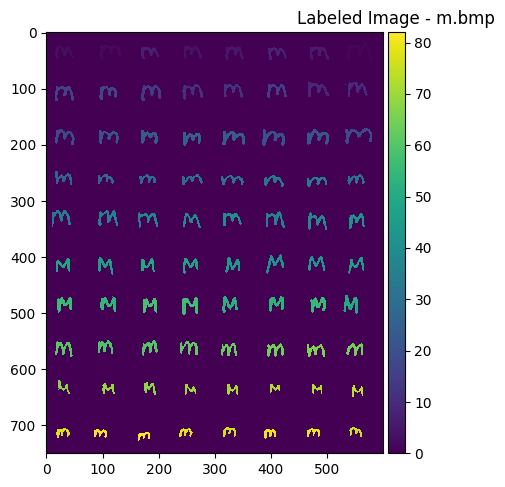

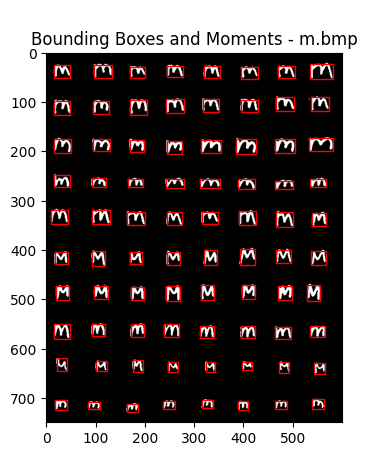

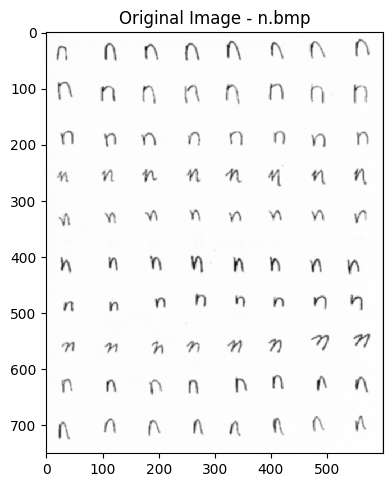

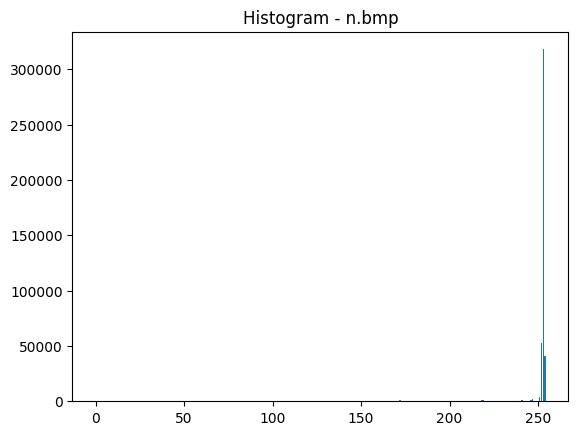

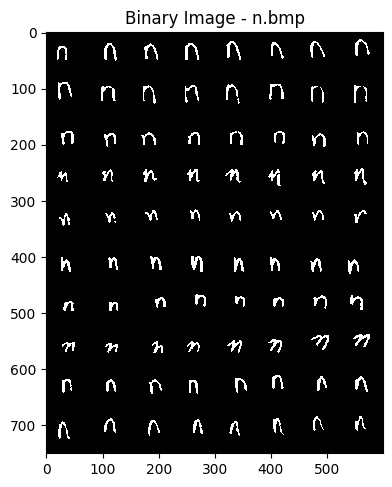

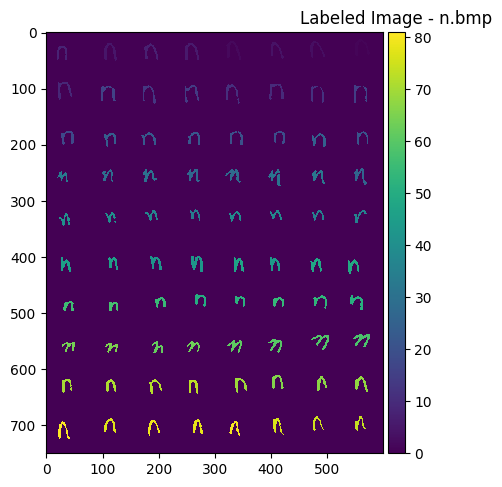

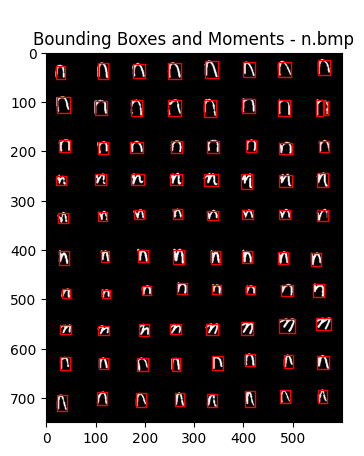

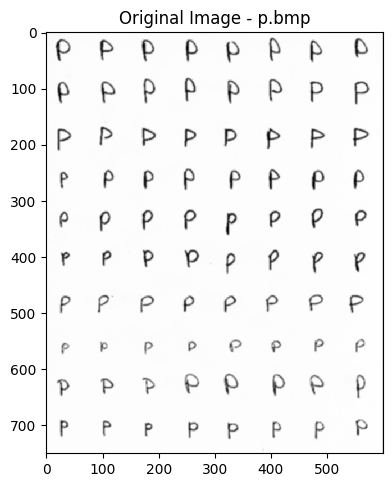

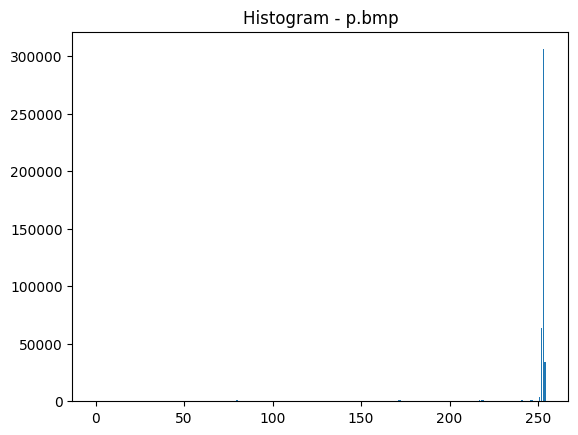

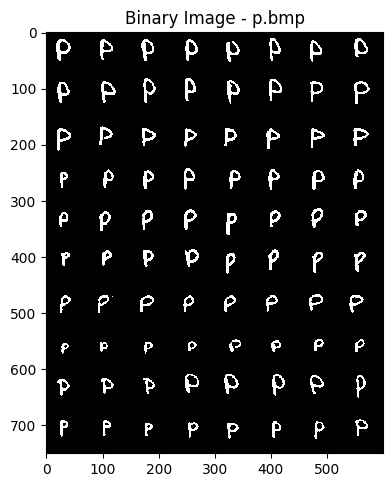

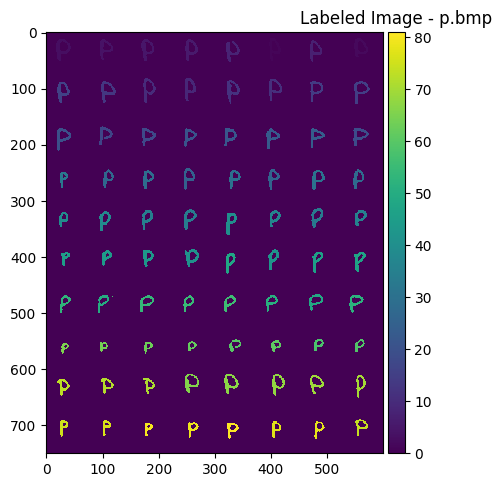

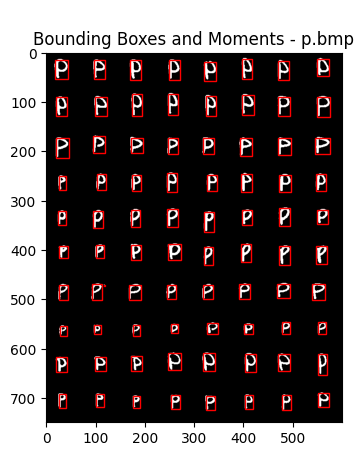

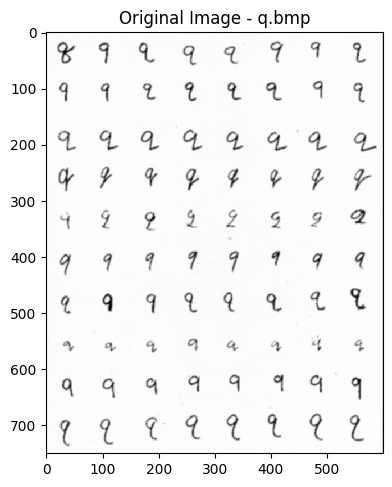

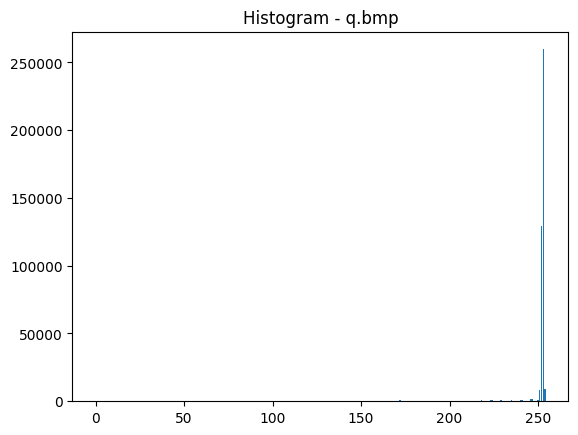

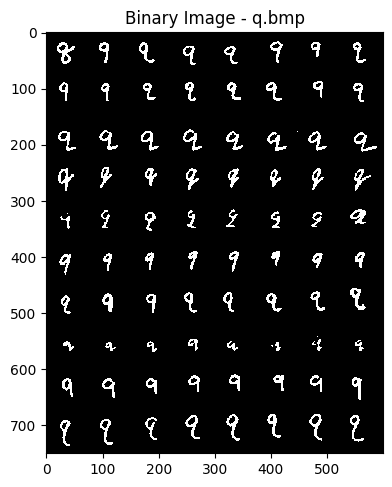

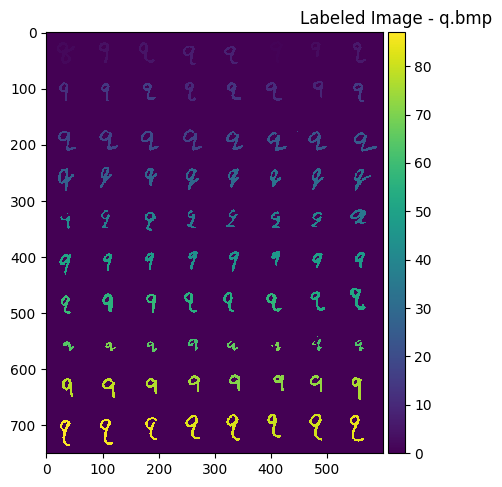

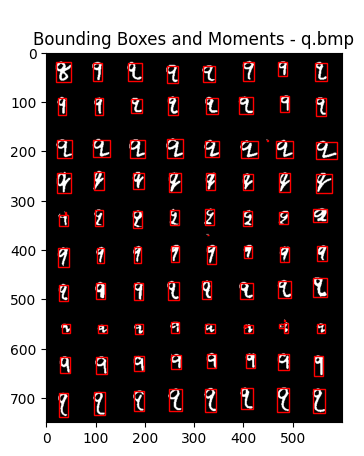

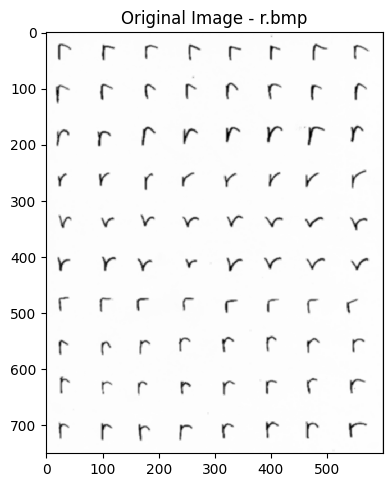

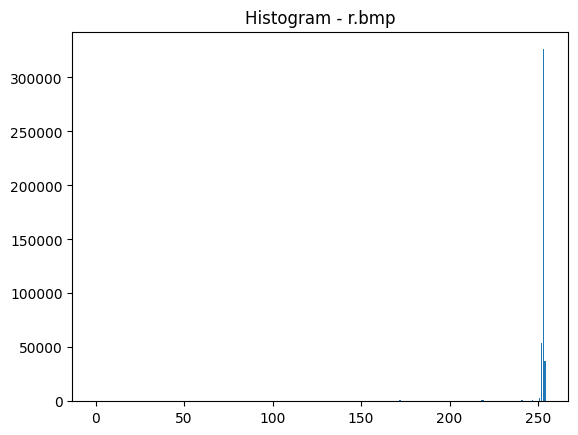

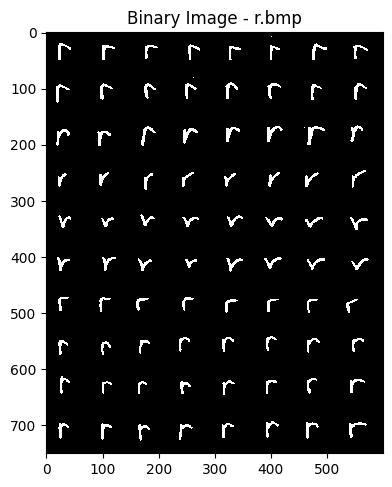

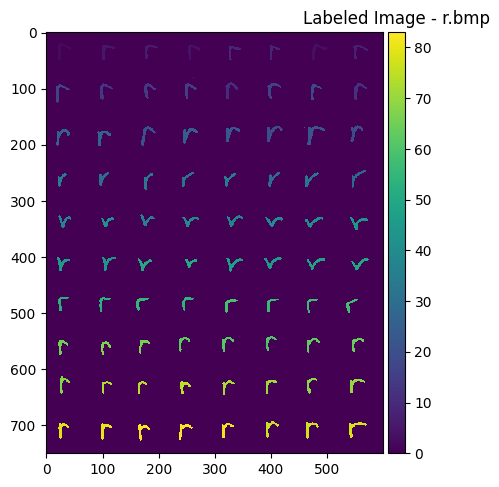

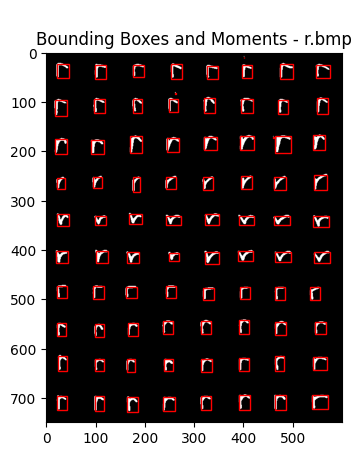

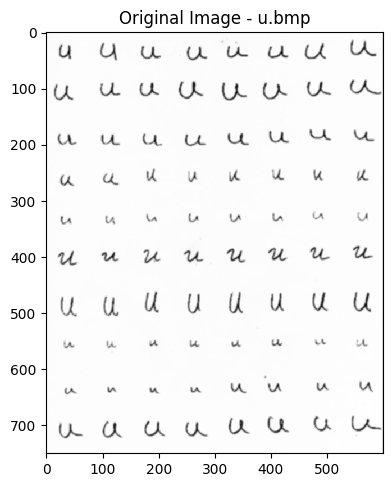

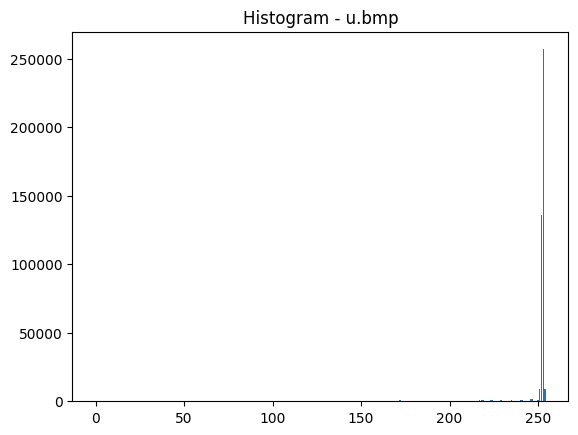

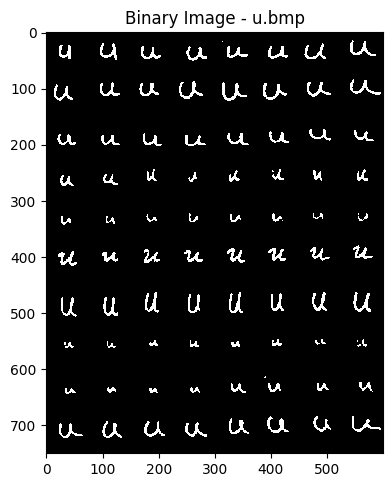

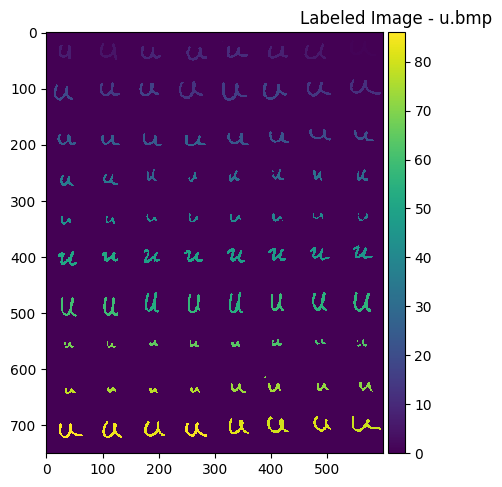

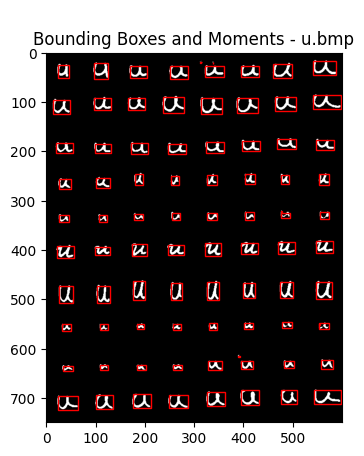

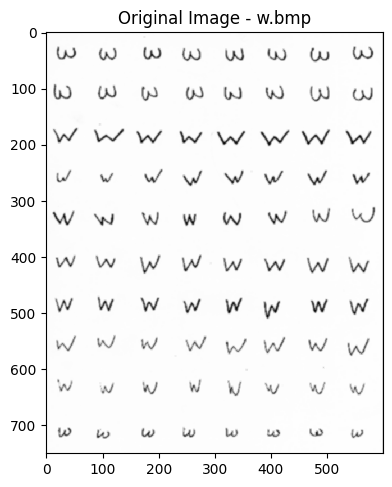

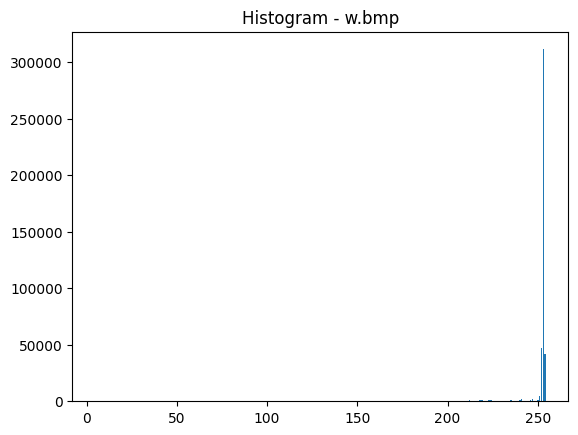

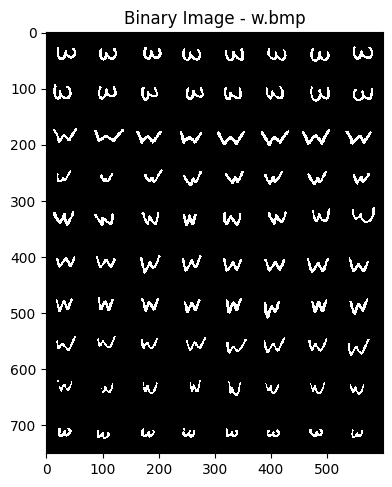

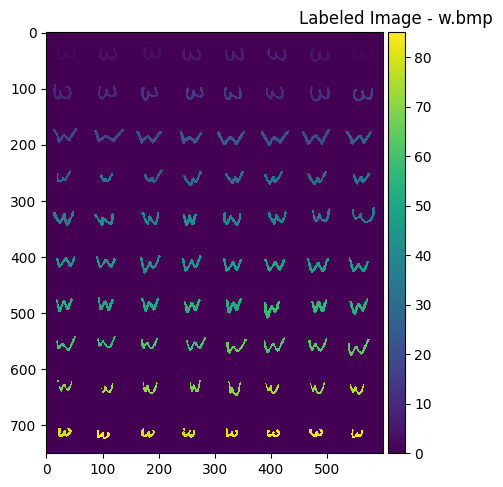

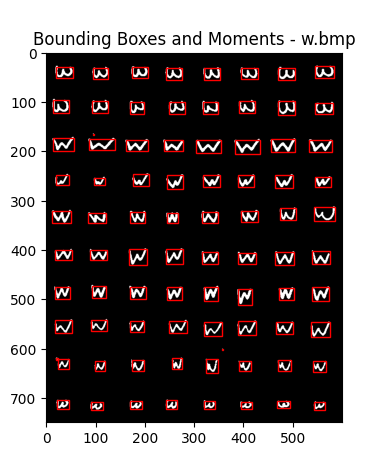

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


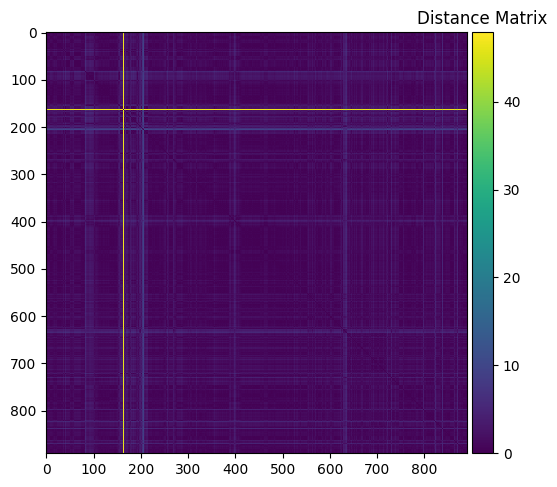

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


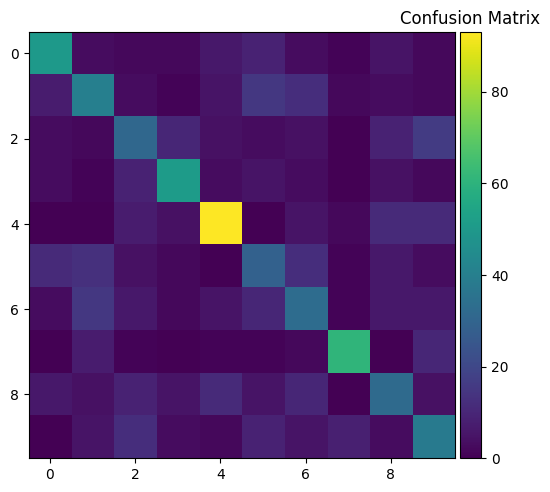

Recognition Rate for a.bmp: 96.39%
Recognition Rate for o.bmp: 90.98%
Recognition Rate for d.bmp: 93.33%
Recognition Rate for m.bmp: 98.78%
Recognition Rate for n.bmp: 100.00%
Recognition Rate for p.bmp: 100.00%
Recognition Rate for q.bmp: 97.70%
Recognition Rate for r.bmp: 97.59%
Recognition Rate for u.bmp: 94.19%
Recognition Rate for w.bmp: 95.29%


In [ ]:
# Testing to see if it works
image_files = ['a.bmp', 'o.bmp', 'd.bmp', 'm.bmp', 'n.bmp', 'p.bmp', 'q.bmp', 'r.bmp', 'u.bmp', 'w.bmp']
features, labels, regions_info = extract_features(image_files, show_plots=True)

# normalization and saving
normalize_and_save(features, labels, regions_info)

# Calculate recognition rate for each image
for image_file in image_files:
    recognition_rate = calculate_recognition_rate(image_file)
    print(f'Recognition Rate for {image_file}: {recognition_rate * 100:.2f}%')
